<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/fastai/05_anneal%2Bfoundations%2Bearly_stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!git clone https://github.com/fastai/course-v3

Cloning into 'course-v3'...
remote: Enumerating objects: 5333, done.
remote: Total 5333 (delta 0), reused 0 (delta 0), pack-reused 5333
Receiving objects: 100% (5333/5333), 257.77 MiB | 42.82 MiB/s, done.
Resolving deltas: 100% (2885/2885), done.


In [3]:
cd course-v3/nbs/dl2

/content/course-v3/nbs/dl2


# anneal

In [0]:
#export
from exp.nb_04 import *

## Initial setup

In [5]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.67106984375, tensor(0.8028)]
valid: [0.3191350830078125, tensor(0.9030)]
train: [0.29694919921875, tensor(0.9125)]
valid: [0.247824609375, tensor(0.9304)]
train: [0.235924375, tensor(0.9312)]
valid: [0.19842041015625, tensor(0.9433)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.76367515625, tensor(0.7983)]
valid: [0.3648052734375, tensor(0.9008)]
train: [0.3496009375, tensor(0.8993)]
valid: [0.3048053955078125, tensor(0.9108)]
train: [0.29737068359375, tensor(0.9147)]
valid: [0.2595988525390625, tensor(0.9264)]


In [0]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer.

In [0]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a pos argument (going from 0 to 1) such that this function goes from start (at pos=0) to end (at pos=1) in a linear fashion.

In [10]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

#We can refactor this with a decorator.

#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

# shift-tab works too, in Jupyter!
# sched_lin()

f = sched_lin(1,2)
f(0.3)

1.3

In [0]:
#And here are other scheduler functions:

#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

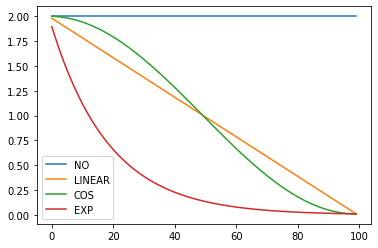

In [12]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

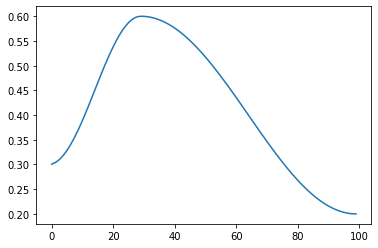

In [13]:
#In practice, we'll often want to combine different schedulers, the following function does that: it uses scheds[i] for pcts[i] of the training.

#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

#Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
plt.plot(a, [sched(o) for o in p])


In [14]:
#We can use it for training quite easily...

cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

run.fit(3, learn)

train: [0.775418671875, tensor(0.7933)]
valid: [0.31850556640625, tensor(0.9065)]
train: [0.30631994140625, tensor(0.9101)]
valid: [0.2339670166015625, tensor(0.9311)]
train: [0.24077845703125, tensor(0.9313)]
valid: [0.211903125, tensor(0.9396)]


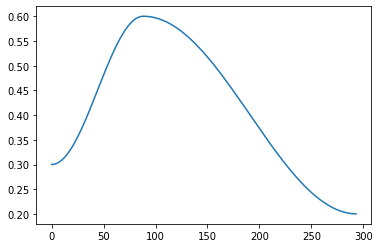

In [15]:
#.. then check with our recorder if the learning rate followed the right schedule.
run.recorder.plot_lr()

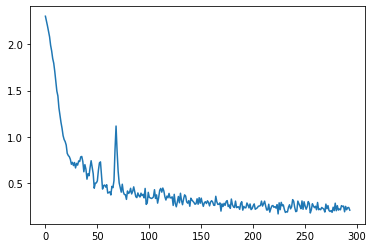

In [16]:
run.recorder.plot_loss()

## Export

In [0]:
#!./notebook2script.py 05_anneal.ipynb

# foundations

In [0]:
import torch
import matplotlib.pyplot as plt

[Jump_to opening comments and overview of lesson 10](https://course.fast.ai/videos/?lesson=10&t=108)

## Callbacks

### Callbacks as GUI events

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=432)

In [0]:
import ipywidgets as widgets

In [0]:
def f(o): print('hi')

From the [ipywidget docs](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Events.html):

- *the button widget is used to handle mouse clicks. The on_click method of the Button can be used to register function to be called when the button is clicked*

In [0]:
w = widgets.Button(description='Click me')

In [0]:
w

Button(description='Click me', style=ButtonStyle())

hi
hi


In [0]:
w.on_click(f)

*NB: When callbacks are used in this way they are often called "events".*

Did you know what you can create interactive apps in Jupyter with these widgets? Here's an example from [plotly](https://plot.ly/python/widget-app/):

![](https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif)

### Creating your own callback

回调函数使用

回调函数是一个函数的合集，会在训练的阶段中所使用。你可以使用回调函数来查看训练模型的内在状态和统计。你可以传递一个列表的回调函数（作为 callbacks 关键字参数）到 Sequential 或 Model 类型的 .fit() 方法。在训练时，相应的回调函数的方法就会被在各自的阶段被调用。

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=680)

In [0]:
from time import sleep

In [0]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [0]:
slow_calculation()

30

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb: cb(i)
    return res

In [0]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [0]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

### Lambdas and partials

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=811)

在训练进行中创建简单，自定义的回调函数的回调函数。

这个回调函数和匿名函数在合适的时间被创建

In [0]:
slow_calculation(lambda o: print(f"Awesome! We've finished epoch {o}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [0]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}!")

In [0]:
slow_calculation(lambda o: show_progress("OK I guess", o))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

In [0]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [0]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [0]:
def make_show_progress(exclamation):
    # Leading "_" is generally understood to be "private"
    def _inner(epoch): print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [0]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [0]:
f2 = make_show_progress("Terrific")

In [0]:
slow_calculation(f2)

Terrific! We've finished epoch 0!
Terrific! We've finished epoch 1!
Terrific! We've finished epoch 2!
Terrific! We've finished epoch 3!
Terrific! We've finished epoch 4!


30

In [0]:
slow_calculation(make_show_progress("Amazing"))

Amazing! We've finished epoch 0!
Amazing! We've finished epoch 1!
Amazing! We've finished epoch 2!
Amazing! We've finished epoch 3!
Amazing! We've finished epoch 4!


30

In [0]:
from functools import partial

In [0]:
slow_calculation(partial(show_progress, "OK I guess"))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

In [0]:
f2 = partial(show_progress, "OK I guess")

### Callbacks as callable classes

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1122)

In [0]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"): self.exclamation = exclamation
    def __call__(self, epoch): print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [0]:
cb = ProgressShowingCallback("Just super")

In [0]:
slow_calculation(cb)

Just super! We've finished epoch 0!
Just super! We've finished epoch 1!
Just super! We've finished epoch 2!
Just super! We've finished epoch 3!
Just super! We've finished epoch 4!


30

### Multiple callback funcs; `*args` and `**kwargs`

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1194)

In [0]:
def f(*args, **kwargs): print(f"args: {args}; kwargs: {kwargs}")

In [0]:
f(3, 'a', thing1="hello")

args: (3, 'a'); kwargs: {'thing1': 'hello'}


NB: We've been guilty of over-using kwargs in fastai - it's very convenient for the developer, but is annoying for the end-user unless care is taken to ensure docs show all kwargs too. kwargs can also hide bugs (because it might not tell you about a typo in a param name). In [R](https://www.r-project.org/) there's a very similar issue (R uses `...` for the same thing), and matplotlib uses kwargs a lot too.

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [0]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print(f"About to start")
    def after_calc (self, *args, **kwargs): print(f"Done step")

In [0]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [0]:
class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs): print(f"About to start: {epoch}")
    def after_calc (self, epoch, val, **kwargs): print(f"After {epoch}: {val}")

In [0]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

### Modifying behavior

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1454)

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb,'before_calc'): cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb,'after_calc'):
            if cb.after_calc(i, res):
                print("stopping early")
                break
    return res

In [0]:
class PrintAfterCallback():
    def after_calc (self, epoch, val):
        print(f"After {epoch}: {val}")
        if val>10: return True

In [0]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [0]:
class SlowCalculator():
    def __init__(self, cb=None): self.cb,self.res = cb,0
    
    def callback(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb,cb_name, None)
        if cb: return cb(self, *args)

    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print("stopping early")
                break

In [0]:
class ModifyingCallback():
    def after_calc (self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res>10: return True
        if calc.res<3: calc.res = calc.res*2

In [0]:
calculator = SlowCalculator(ModifyingCallback())

In [0]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

## `__dunder__` thingies

Anything that looks like `__this__` is, in some way, *special*. Python, or some library, can define some functions that they will call at certain documented times. For instance, when your class is setting up a new object, python will call `__init__`. These are defined as part of the python [data model](https://docs.python.org/3/reference/datamodel.html#object.__init__).

For instance, if python sees `+`, then it will call the special method `__add__`. If you try to display an object in Jupyter (or lots of other places in Python) it will call `__repr__`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1647)

In [0]:
class SloppyAdder():
    def __init__(self,o): self.o=o
    def __add__(self,b): return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self): return str(self.o)

In [0]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a+b

3.01

Special methods you should probably know about (see data model link above) are:

- `__getitem__`
- `__getattr__`
- `__setattr__`
- `__del__`
- `__init__`
- `__new__`
- `__enter__`
- `__exit__`
- `__len__`
- `__repr__`
- `__str__`

## Variance and stuff

### Variance

Variance is the average of how far away each data point is from the mean. E.g.:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2133)

In [0]:
t = torch.tensor([1.,2.,4.,18])

In [0]:
m = t.mean(); m

tensor(6.2500)

In [0]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [0]:
(t-m).pow(2).mean()

tensor(47.1875)

In [0]:
(t-m).abs().mean()

tensor(5.8750)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [0]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [0]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance and correlation

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2414)

In [0]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code. So now we need two vectors.

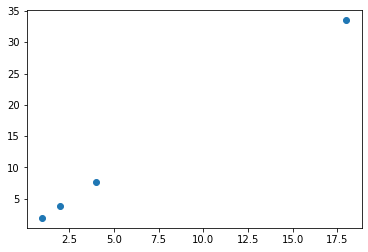

In [0]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [0]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.4734,  33.3787,   9.2685, 255.8870])

In [0]:
prod.mean()

tensor(87.5019)

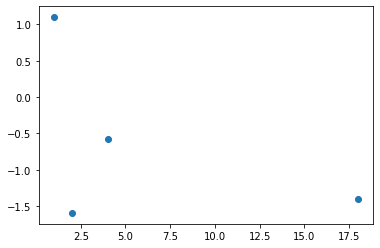

In [0]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [0]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-3.5397)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [0]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-3.5397)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [0]:
cov / (t.std() * v.std())

tensor(-0.3640)

It's just a scaled version of the same thing. Question: *Why is it scaled by standard deviation, and not by variance or mean or something else?*

## Softmax

Here's our final `logsoftmax` definition:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2674)

In [0]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$ 

And our cross entropy loss is:
$$-\log(p_{i})$$

## Browsing source code

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1782)

- Jump to tag/symbol by with (with completions)
- Jump to current tag
- Jump to library tags
- Go back
- Search
- Outlining / folding

#  early_stopping

In [0]:
#export
from exp.nb_05 import *

## Early stopping

### Better callback cancellation

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

In [22]:
learn = create_learner(get_model, loss_func, data)

class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

run = Runner(cb_funcs=TestCallback)

run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


## Other callbacks

In [0]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

## LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [0]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for best_loss*3 instead of best_loss x 10.

In [0]:
learn = create_learner(get_model, loss_func, data)

run = Runner(cb_funcs=[LR_Find, Recorder])

run.fit(2, learn)

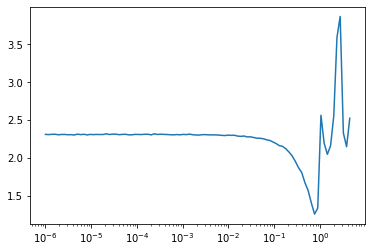

In [26]:
run.recorder.plot(skip_last=5)

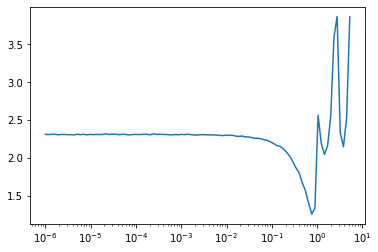

In [29]:
run.recorder.plot(skip_last=4)

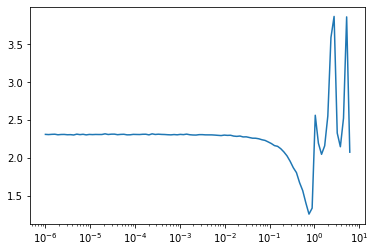

In [30]:
run.recorder.plot(skip_last=3)

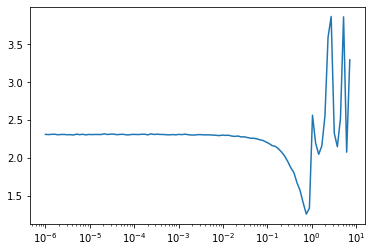

In [31]:
run.recorder.plot(skip_last=2)

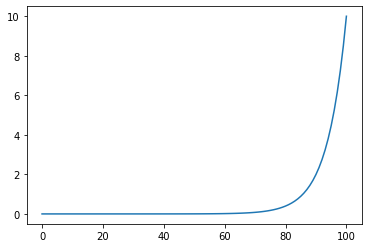

In [27]:
run.recorder.plot_lr()

## Export

In [0]:
#!python notebook2script.py 05b_early_stopping.ipynb